In [178]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#!pip install scikit-learn==0.24.0

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression

from sklearn.cluster import k_means
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
!pip install hdbscan
!pip install fa_kit
!pip install kneed
from fa_kit.rotation import VarimaxRotatorPython

from sklearn import metrics
import os

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model

In [ ]:
folder = 'baby_k10_e1_lof'

In [179]:
def read_file(dfs):
    df = pd.DataFrame()
    path = '/home/jovyan/work/Toni/detection_of_IoT_botnet_attacks_N_BaIoT/anonymized/alex2/'+folder+'/'
    df_new = pd.read_csv(path+'benign_traffic.csv')
    df_new['label'] = 'benign_traffic'
    df = pd.concat([df,df_new], ignore_index=True)
    
    directory = os.fsencode(path+'gafgyt_attacks')
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"): 
            df_new = pd.read_csv(path+'gafgyt_attacks'+'/'+filename)
            filename=filename[:-4] 
            df_new['label'] = 'gafgyt_'+filename
            df = pd.concat([df,df_new], ignore_index=True)
    directory = os.fsencode(path+'mirai_attacks')
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"): 
            df_new = pd.read_csv(path+'mirai_attacks'+'/'+filename)
            filename=filename[:-4] 
            df_new['label'] = 'mirai_'+filename
            df = pd.concat([df,df_new], ignore_index=True)
    return df

In [180]:
df = read_file(folder)
df = df.dropna().reset_index(drop=True)

In [4]:
def pca_func(rate, data):    
    df_wo_label = data.drop(columns = ['label'])
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_wo_label)
    pca = PCA(n_components=rate, random_state=0)
    pca_comp = pca.fit(data_scaled).components_
    return pca_comp, data_scaled

In [5]:
# LEts transform our original dataset to lower dimensional
def decrease_dim(components, data_scaled):
    varimax = VarimaxRotatorPython()
    rotated_weights = varimax.rotate(components.T)
    df_lowdim = pd.DataFrame(np.dot(data_scaled, rotated_weights))
    #df_lowdim["label"] = df["label"]
    rotated_data = np.dot(data_scaled, rotated_weights)
    return df_lowdim, rotated_data

In [6]:
import scipy.special

def adj_rand(data):
    tab = pd.crosstab(data['label'], data['cluster_label'])
    df_tab = pd.DataFrame(tab)
    a = list(df_tab.sum(axis=1))
    b = list(df_tab.sum(axis=0))
    n = df_tab.values.tolist()
    sum_n = 0
    for i in range(len(n)):
        for j in range(len(n[0])):
            sum_n += scipy.special.comb(n[i][j],2)
    sum_a = 0
    for k in range(len(a)):
        sum_a += scipy.special.comb(a[k],2)
    sum_b = 0
    for l in range(len(b)):
        sum_b += scipy.special.comb(b[l],2)
    
    ari = (sum_n - sum_a*sum_b/scipy.special.comb(sum(a),2))/(0.5*(sum_a+sum_b)-sum_a*sum_b/scipy.special.comb(sum(a),2))
    return(ari)

In [7]:
def evall(df_cl):
    sc = []
    sc.append(metrics.rand_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(adj_rand(df_cl))
    sc.append(metrics.mutual_info_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(metrics.adjusted_mutual_info_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(metrics.homogeneity_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(metrics.completeness_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(metrics.v_measure_score(df_cl['label'], df_cl['cluster_label']))
    sc.append(metrics.fowlkes_mallows_score(df_cl['label'], df_cl['cluster_label']))
    return sc

In [8]:
def L_method_optimum(tofit, minima=0):
    maxima = len(tofit)
    # minima=0
    regr = linear_model.LinearRegression()
    x_axis=np.arange(minima,maxima)
    mse=np.zeros(maxima-minima)
    xo =np.zeros(maxima-minima)
    for i in range(2,maxima-minima-2):
        #print(i)
        guess11=regr.fit(x_axis[i:].reshape(-1, 1),tofit[i:].reshape(-1, 1)).predict(x_axis[i:].reshape(-1, 1))
        guess1= regr.fit(x_axis[i:].reshape(-1, 1),tofit[i:].reshape(-1, 1))
        a= guess1.coef_
        b= guess1.intercept_
        guess22=regr.fit(x_axis[:i].reshape(-1, 1),tofit[:i].reshape(-1, 1)).predict(x_axis[:i].reshape(-1, 1))
        guess2 =regr.fit(x_axis[:i].reshape(-1, 1),tofit[:i].reshape(-1, 1))
        c= guess2.coef_
        d= guess2.intercept_
        mse[i]= (maxima-minima-i+1)*mean_squared_error(tofit[i:], guess11 )+i*mean_squared_error(tofit[:i], guess22)
        xo[i]=(d-b)/(a-c)
        min_place=np.argmin(mse[2:-2])+2+minima
    #labels = hierarchy.fcluster(linkage, minhely, 'maxclust')
    return (min_place) #, distances[min_place])

In [47]:
df_eval = pd.DataFrame(columns = ['rand_score', 'adjusted_rand_score', 'mutual_info_score', 'adjusted_mutual_info_score', 
                                  'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score'])

# K-MEANS

In [45]:
def kmeans(low_data, num_cl):
    low_data_2 = low_data.copy()
    kmeans = KMeans(init="random",n_clusters=num_cl,n_init=10,max_iter=200,random_state=42)
    kmeans.fit(low_data_2)
    low_data_2["cluster_label"] = kmeans.labels_
    low_data_2["label"] = df["label"]
    return low_data_2

In [46]:
comp, df_scaled = pca_func(0.7, df)
df_low, np_low = decrease_dim(comp, df_scaled)

In [12]:
kmeans_kwargs = {"init": "random","n_init": 10, "max_iter": 200,"random_state": 42}

sse = []
for k in range(1, 100):
    print(k)
    kmeanss =  MiniBatchKMeans(n_clusters=k, **kmeans_kwargs)
    kmeanss.fit(df_low)
    sse.append(kmeanss.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


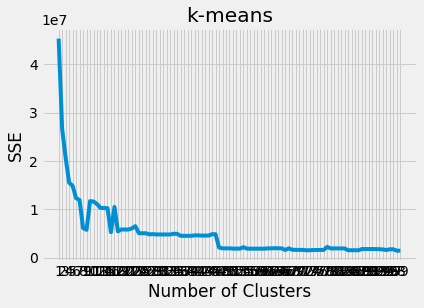

In [13]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 100), sse)
plt.xticks(range(1, 100))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('k-means')
plt.show()

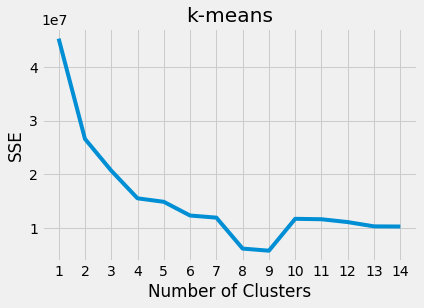

In [14]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse[:14])
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('k-means')
plt.show()

In [15]:
sse = np.array(sse)
L_method_optimum(sse)

4

In [48]:
for k in range(3,13):
    print(k)
    df_kmeans = kmeans(df_low, k)
    df_eval.loc['kmeans_cl'+str(k)]=evall(df_kmeans)

3
4
5
6
7
8
9
10
11
12


In [49]:
df_eval.to_csv('eval_baby_k10_e1_lof')

# MINIBATCH KMEANS

In [51]:
def minibatch(low_data, num_cl):
    low_data_2 = low_data.copy()
    mini_kmeans = MiniBatchKMeans(init="random",n_clusters=num_cl,n_init=10,max_iter=200,random_state=42)
    mini_kmeans.fit(low_data_2)
    low_data_2["cluster_label"] = mini_kmeans.labels_
    low_data_2["label"] = df["label"]
    return low_data_2

In [19]:
comp, df_scaled = pca_func(0.7, df)
df_low, np_low = decrease_dim(comp, df_scaled)

kmeans_kwargs = {"init": "random","n_init": 10, "max_iter": 200,"random_state": 42}

# A list holds the SSE values for each k
sse = []
for k in range(1, 100):
    print(k)
    kmeanss =  MiniBatchKMeans(n_clusters=k, **kmeans_kwargs)
    kmeanss.fit(df_low)
    sse.append(kmeanss.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


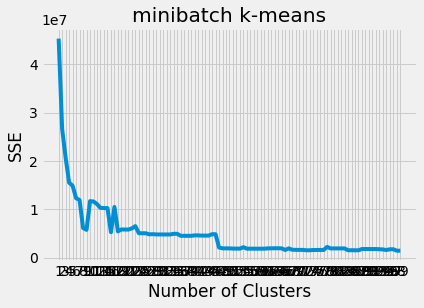

In [20]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 100), sse)
plt.xticks(range(1, 100))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('minibatch k-means')
plt.show()

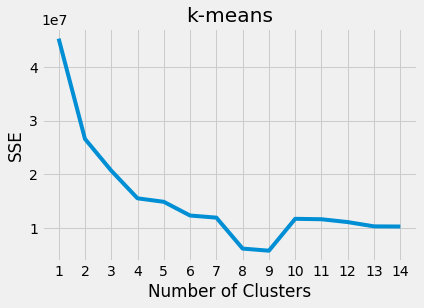

In [21]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse[:14])
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('k-means')
plt.show()

In [22]:
sse = np.array(sse)
L_method_optimum(sse)

4

In [52]:
for k in range(3,13):
    print(k)
    df_kmeans = minibatch(df_low, k)
    df_eval.loc['minibatch_kmeans_cl'+str(k)]=evall(df_kmeans)

3
4
5
6
7
8
9
10
11
12


In [53]:
df_eval.to_csv('eval_baby_k10_e1_lof.csv')

In [35]:
df_reduced = df.sample(n=100000)
df_reduced2 = df_reduced.copy()
reduced_label = df_reduced['label'].reset_index(drop=True)
comp, df_scaled = pca_func(0.7, df_reduced)
df_low, np_low = decrease_dim(comp, df_scaled)

In [38]:
df_reduced2 = df_reduced.reset_index(drop=True)
df_reduced2["cluster_label"] = df_dbscan["cluster_label"]
df_reduced2

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,label,cluster_label
0,203.819703,356.697910,5.486466e+04,198.504988,365.880277,54585.376215,678.900933,387.827823,57284.748283,6362.219834,...,0.0,1.000000,554.0,0.000000e+00,554.0,0.000000e+00,0.0,0.000000e+00,mirai_udp,0
1,109.290736,70.947197,3.544633e+01,209.737374,70.463947,40.898632,668.106228,69.447695,42.878277,5533.801214,...,0.0,1.000000,74.0,-5.421011e-20,74.0,-4.336809e-19,0.0,0.000000e+00,mirai_syn,0
2,135.010946,428.239787,5.622282e+04,242.051343,413.127356,53220.327955,649.062778,390.878574,57411.873783,6362.778551,...,0.0,1.000000,566.0,-1.033976e-25,566.0,-4.930381e-32,0.0,0.000000e+00,mirai_ack,1
3,17.391256,60.000646,1.230460e-01,50.886627,60.010915,0.248609,191.670155,60.072321,3.227399,2217.257313,...,0.0,1.000000,60.0,-1.033976e-25,60.0,9.860761e-32,0.0,0.000000e+00,mirai_scan,0
4,14.009700,75.682940,1.948207e+01,19.243650,73.000407,103.479521,83.270992,74.959714,15.348163,701.452601,...,0.0,1.000000,74.0,1.110223e-16,74.0,0.000000e+00,0.0,-4.336809e-19,gafgyt_scan,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,127.171781,293.838381,6.484829e+04,206.440767,380.438668,59551.675464,613.131397,393.973619,57568.985471,6318.882297,...,0.0,1.000000,60.0,-1.033976e-25,60.0,-4.930381e-32,0.0,0.000000e+00,mirai_ack,4
99996,31.318997,60.000000,5.716281e-07,42.924589,60.000010,-0.000038,182.824518,60.007209,0.194061,2240.171671,...,0.0,1.000000,60.0,-1.033976e-25,60.0,9.860761e-32,0.0,0.000000e+00,mirai_scan,5
99997,38.398242,74.075931,2.855491e+00,51.927260,74.205262,3.444985,103.787244,74.403080,26.200764,1028.183516,...,0.0,2.898635,74.0,-1.163137e-06,74.0,1.932676e-12,0.0,-4.336809e-19,gafgyt_scan,0
99998,147.544720,354.355578,6.138795e+04,222.665315,393.631798,50104.635875,653.344058,385.449040,54832.611874,6418.485697,...,0.0,1.000000,60.0,0.000000e+00,60.0,0.000000e+00,0.0,0.000000e+00,mirai_udp,4


# HIERARCHICAL

In [8]:
!pip install -U scikit-learn


Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.7/site-packages (0.24.1)


In [9]:
def hierarch(low_data, num_clust, link):
    low_data_2 = low_data.copy()
    hier = AgglomerativeClustering(n_clusters=num_clust, linkage=link).fit(low_data_2)
    low_data_2["cluster_label"] = hier.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

In [18]:
df_reduced = df.sample(n=100000)
reduced_label = df_reduced['label'].reset_index(drop=True)
comp, df_scaled = pca_func(0.7, df_reduced)
df_low, np_low = decrease_dim(comp, df_scaled)

In [12]:
for k in range(9, 10):
    print(k)
    df_hierarch = hierarch(df_low, k, 'ward')
    print(evall(df_hierarch))
    #df_eval.loc['hierarch_cl'+str(k)]=evall(df_hierarch)

9
[0.8501949091490915, 0.4567743548398564, 1.3370683008640414, 0.6804226494950849, 0.5944406295772461, 0.7956661764034433, 0.680489154933543, 0.5596923030623164]


# MEAN-SHIFT

In [54]:
def mean_shift(low_data):
    low_data_2 = low_data.copy()
    mean_sh = MeanShift().fit(low_data_2)
    low_data_2["cluster_label"] = mean_sh.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

In [68]:
df_meanshift = mean_shift(df_low)
df_eval.loc['meanshift']=evall(df_meanshift)
df_eval.to_csv('eval_baby_k10_e1_lof.csv')

# DBSCAN

In [8]:
def dbscan(low_data, ep, min_samp):
    low_data_2 = low_data.copy()
    dbsc = DBSCAN(eps=ep, min_samples=min_samp).fit(low_data_2)
    low_data_2["cluster_label"] = dbsc.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

In [183]:
df_eval

,Unnamed: 0,rand_score,adjusted_rand_score,mutual_info_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score,fowlkes_mallows_score
0,kmeans_cl3,0.708704,0.255592,0.799839,0.482866,0.355356,0.753119,0.482872,0.448918
1,kmeans_cl4,0.710012,0.256463,0.812240,0.487828,0.360866,0.752659,0.487836,0.449030
2,kmeans_cl5,0.730739,0.266335,0.935681,0.532688,0.415709,0.741320,0.532698,0.445409
3,kmeans_cl6,0.746472,0.285778,1.044503,0.576720,0.464057,0.761666,0.576731,0.456549
4,kmeans_cl7,0.746339,0.285837,1.043776,0.576272,0.463734,0.760979,0.576285,0.456731
5,kmeans_cl8,0.834239,0.422736,1.226103,0.640718,0.544739,0.777789,0.640730,0.537385
6,kmeans_cl9,0.886005,0.528582,1.469567,0.711638,0.652906,0.782006,0.711649,0.600654
7,kmeans_cl10,0.885849,0.527618,1.470103,0.711093,0.653145,0.780352,0.711104,0.599712
8,kmeans_cl11,0.883005,0.510265,1.471118,0.704380,0.653595,0.763752,0.704393,0.582880
9,kmeans_cl12,0.882056,0.477909,1.478544,0.687077,0.656895,0.720200,0.687092,0.547359


Text(0, 0.5, 'Distance')

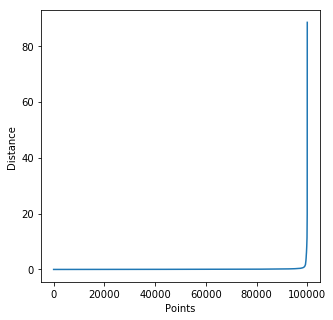

In [35]:
#estimating epsilon

from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(np_low)
distances, indices = neighbors.kneighbors(np_low)

distances = np.sort(distances[:,10], axis=0)

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

Text(0, 0.5, 'Distance')

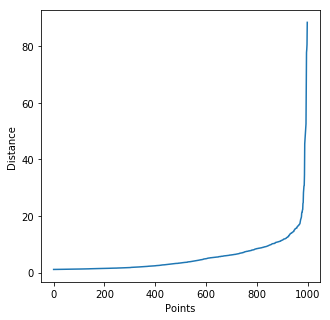

In [36]:
fig = plt.figure(figsize=(5, 5))
plt.plot(distances[99000:100000])
plt.xlabel("Points")
plt.ylabel("Distance")

In [62]:
eval_dbscan = []
for j in [0.18,0.19,0.2,0.21,0.22, 0.23, 0.24]:
    print(j)
    df_dbscan = dbscan(df_low, j, 10)
    metrics_dbscan = evall(df_dbscan)
    eval_dbscan.append(metrics_dbscan)

0.18
0.19
0.2
0.21
0.22
0.23
0.24


In [65]:
eval_dbscan

[[0.9166624850248503,
  0.6049471671971435,
  1.8034350981801008,
  0.7885599120855519,
  0.8015618994231474,
  0.7770613967737778,
  0.7891215221097236,
  0.6523701806336502],
 [0.9164266914669147,
  0.6037880443162899,
  1.797629177704337,
  0.7889412279134281,
  0.7989813770360932,
  0.779793265425254,
  0.7892707169930301,
  0.6513429257748599],
 [0.9161429698296983,
  0.6021982024418004,
  1.7932660953766586,
  0.7873389272534079,
  0.7970421442012423,
  0.7784847179282813,
  0.7876541412525238,
  0.6499030591138785],
 [0.9158072992729928,
  0.6002693749145823,
  1.7885994061379913,
  0.7857906130025577,
  0.7949679690374459,
  0.7773457322651652,
  0.7860580970665085,
  0.6481500747759592]]

In [64]:
eval_dbscan = []
for i in [3,4,5,6]:
    df_dbscan = dbscan(df_low, 0.21, i)
    metrics_dbscan = evall(df_dbscan)
    eval_dbscan.append(metrics_dbscan)

In [19]:
df_dbscan = dbscan(df_low, 0.21, 5)

In [176]:
evall(df_dbscan)

[0.904109880498805,
 0.562892910678004,
 1.6879440734058244,
 0.7581095929822944,
 0.7497154012716013,
 0.7673268091917702,
 0.758418879437706,
 0.6186828124568348]

## Building tree

In [182]:
df_eval = pd.read_csv('eval_baby_k10_e1_lof')

In [163]:
def evall_2(label_pred, label_true):
    sc = []
    sc.append(metrics.rand_score(label_true, label_pred))
    #sc.append(adj_rand(df_cl))
    sc.append(metrics.mutual_info_score(label_true, label_pred))
    sc.append(metrics.adjusted_mutual_info_score(label_true, label_pred))
    sc.append(metrics.homogeneity_score(label_true, label_pred))
    sc.append(metrics.completeness_score(label_true, label_pred))
    sc.append(metrics.v_measure_score(label_true, label_pred))
    sc.append(metrics.fowlkes_mallows_score(label_true, label_pred))
    return sc

In [164]:
df_reduced = df.sample(n=100000)
df_reduced2 = df_reduced.copy()
reduced_label = df_reduced['label'].reset_index(drop=True)
comp, df_scaled = pca_func(0.7, df_reduced)
df_low, np_low = decrease_dim(comp, df_scaled)

In [165]:
df_reduced2 = df_reduced.reset_index(drop=True)
df_dbscan = dbscan(df_low, 0.21, 5)
df_reduced2["cluster_label"] = df_dbscan["cluster_label"]

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,label,cluster_label
0,125.901863,335.139805,57481.958123,306.446853,354.676361,6.181608e+04,664.579534,374.485764,57264.235429,6475.821617,...,0.000000,1.000000,554.000000,0.000000e+00,554.000000,0.000000e+00,0.000000e+00,0.000000,mirai_udp,0
1,98.326409,500.973654,29692.234932,179.690401,428.017341,4.179458e+04,603.330455,407.446978,52870.611919,6376.081164,...,0.000000,1.000000,554.000000,0.000000e+00,554.000000,0.000000e+00,0.000000e+00,0.000000,mirai_udp,0
2,134.926584,70.478628,39.136210,211.400001,69.139934,4.107262e+01,667.315990,69.326409,43.858760,6456.780850,...,0.000000,1.000000,74.000000,-5.421011e-20,74.000000,-4.336809e-19,0.000000e+00,0.000000,mirai_syn,1
3,1.000000,60.000000,0.000000,1.000000,60.000000,3.552714e-15,1.000000,60.000000,0.000000,1.000000,...,0.000000,1.000000,60.000000,0.000000e+00,60.000000,-3.552714e-15,-2.220446e-16,0.000000,gafgyt_tcp,2
4,128.267111,69.535317,58.842471,220.844630,72.590817,4.085348e+01,691.159620,69.886060,41.033340,6208.281444,...,0.000000,1.000000,60.000000,-5.421011e-20,60.000000,-4.336809e-19,0.000000e+00,0.000000,mirai_syn,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.000000,60.000000,0.000000,1.000000,60.000000,3.552714e-15,1.000000,60.000000,0.000000,1.000000,...,0.000000,1.000000,60.000000,0.000000e+00,60.000000,-3.552714e-15,-2.220446e-16,0.000000,gafgyt_tcp,2
99996,2.010038,66.474783,160.423114,2.437511,71.684766,2.060580e+02,1.773186,59.641278,360.226315,11.382726,...,0.000001,19.078358,65.899102,8.004701e-01,116.557925,2.760612e+02,6.431006e-02,-0.012855,benign_traffic,7
99997,122.323747,234.507597,56905.442998,188.827324,274.547015,5.907392e+04,471.432747,324.101928,60767.408963,5016.433930,...,0.000000,1.000000,60.000000,3.388132e-21,60.000000,2.067952e-25,0.000000e+00,0.000000,mirai_udpplain,9
99998,12.232705,957.734656,380102.267679,11.430020,1068.780705,4.455091e+05,4.380131,657.775680,268019.233425,32.940293,...,1.528174,6.663063,773.544223,7.143170e+02,888.702631,5.239170e+05,7.636577e+04,1.604652,benign_traffic,-1


In [166]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.spatial import distance
from scipy.cluster import hierarchy

import seaborn as sns; sns.set();
from seaborn import heatmap

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model

import networkx as nx

import random as random
from sklearn.multiclass import OneVsRestClassifier

from xgboost import XGBClassifier

import itertools as it
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import accuracy_score
import pickle
from datetime import date
y = df_reduced2['cluster_label'][:90000]
X = df_low.iloc[:90000,:]
dt = OneVsRestClassifier(XGBClassifier(random_state=4, max_depth=8), n_jobs=7)
dt.fit(X, y)

OneVsRestClassifier(estimator=XGBClassifier(max_depth=8, random_state=4),
                    n_jobs=7)

In [167]:
test_label = dt.predict(df_low.iloc[90000:,:])
true_label = df_reduced2['cluster_label'][90000:]

In [168]:
print(metrics.accuracy_score(test_label, true_label))

0.9922


In [169]:
evall_2(test_label, reduced_label[90000:])

[0.9052752475247525,
 1.6911935680147951,
 0.7588568788732253,
 0.7519228867588764,
 0.7687806063904686,
 0.7602583086650282,
 0.6214492078594916]

In [170]:
#read in original data (wo anonymization)
def read_file_o(dfs):
    df = pd.DataFrame()
    for i in dfs:
        df_new = pd.read_csv(i+'.csv')
        df_new['label'] = i
        df = pd.concat([df,df_new], ignore_index=True)
    return df

In [171]:
files = ['benign_traffic', 'bashlite_combo', 'bashlite_junk', 'bashlite_scan', 'bashlite_tcp', 'bashlite_udp',
       'mirai_ack', 'mirai_scan', 'mirai_syn', 'mirai_udp', 'mirai_udpplain']
df_original = read_file_o(files)
df_original = df.dropna().reset_index(drop=True)

In [172]:
#apply same pca to original dataset

#scaling
df_o_wo_label = df_original.drop(columns = ['label'])
scaler = StandardScaler()
data_o_scaled = scaler.fit_transform(df_o_wo_label)
#decrease dim
varimax = VarimaxRotatorPython()
rotated_weights = varimax.rotate(comp.T)
df_o_lowdim = pd.DataFrame(np.dot(data_o_scaled, rotated_weights))

In [173]:
#apply same tree
test_label_o = dt.predict(df_o_lowdim)
true_label_o = df_original['label']

In [174]:
evall_2(test_label_o, true_label_o)

[0.9015383133020007,
 1.6552098047733685,
 0.7516592634265697,
 0.7353846482238264,
 0.7687878455158037,
 0.7517153540387167,
 0.6143043931003308]

## Classification

In [159]:
from sklearn.neighbors import NearestCentroid
import numpy as np

df_reduced = df.sample(n=100000)
reduced_label = df_reduced['label'].reset_index(drop=True)

y_cl = reduced_label[:90000]
X_cl = df_reduced.iloc[:90000,:115]

dt = OneVsRestClassifier(XGBClassifier(random_state=4, max_depth=8), n_jobs=7)
dt.fit(X_cl, y_cl)

test_label_cl = dt.predict(df_reduced.iloc[90000:,:115])
true_label_cl = reduced_label[90000:]


In [160]:
print(metrics.accuracy_score(test_label_cl, true_label_cl))

0.9998


In [161]:
#test classification on original dataset

test_label_cl_o = dt.predict(df_original.iloc[:,:115])
true_label_cl_o = df_original['label']

In [162]:
print(metrics.accuracy_score(test_label_cl_o, true_label_cl_o))

0.9998643730224936


# OPTICS

In [58]:
def optics(low_data):
    low_data_2 = low_data.copy()
    opti = OPTICS().fit(low_data_2)
    low_data_2["cluster_label"] = opti.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

In [59]:
df_optics = optics(df_low)
df_eval.loc['optics']=evall(df_optics)
df_eval.to_csv('eval_baby_k10_e1_lof')

In [60]:
df_eval

,rand_score,adjusted_rand_score,mutual_info_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score,fowlkes_mallows_score
kmeans_cl3,0.708704,0.255592,0.799839,0.482866,0.355356,0.753119,0.482872,0.448918
kmeans_cl4,0.710012,0.256463,0.812240,0.487828,0.360866,0.752659,0.487836,0.449030
kmeans_cl5,0.730739,0.266335,0.935681,0.532688,0.415709,0.741320,0.532698,0.445409
kmeans_cl6,0.746472,0.285778,1.044503,0.576720,0.464057,0.761666,0.576731,0.456549
kmeans_cl7,0.746339,0.285837,1.043776,0.576272,0.463734,0.760979,0.576285,0.456731
kmeans_cl8,0.834239,0.422736,1.226103,0.640718,0.544739,0.777789,0.640730,0.537385
kmeans_cl9,0.886005,0.528582,1.469567,0.711638,0.652906,0.782006,0.711649,0.600654
kmeans_cl10,0.885849,0.527618,1.470103,0.711093,0.653145,0.780352,0.711104,0.599712
kmeans_cl11,0.883005,0.510265,1.471118,0.704380,0.653595,0.763752,0.704393,0.582880
kmeans_cl12,0.882056,0.477909,1.478544,0.687077,0.656895,0.720200,0.687092,0.547359


# HDBSCAN

In [34]:
def hdbscann(low_data):
    low_data_2 = low_data.copy()
    hdb = hdbscan.HDBSCAN().fit(low_data_2)
    low_data_2["cluster_label"] = hdb.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

In [35]:
df_hdbscan = hdbscann(df_low)
df_eval.loc['hdbscan']=evall(df_hdbscan)
df_eval.to_csv('eval_baby_k10_e1')

NameError: name 'hdbscan' is not defined

# SPECTRAL

In [13]:
df_reduced = df.sample(n=50000)
reduced_label = df_reduced['label'].reset_index(drop=True)
comp, df_scaled = pca_func(0.7, df_reduced)
df_low, np_low = decrease_dim(comp, df_scaled)

In [14]:
from sklearn.cluster import SpectralClustering

def spectral(low_data):
    low_data_2 = low_data.copy()
    spectra = SpectralClustering().fit(low_data_2)
    low_data_2["cluster_label"] = spectra.labels_
    low_data_2["label"] = reduced_label
    return low_data_2

In [15]:
df_spectra = spectral(df_low)
print(evall(df_spectra))
#df_eval.loc['spectral']=evall(df_spectra)
#df_eval.to_csv('eval_baby_k10_e1_lof')

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 